## 1. Install Dependencies

In [3]:
!pip install ultralytics pandas numpy matplotlib psutil onnxruntime tensorflow -q

In [4]:
# Import libraries
import os
import gc
import time
import json
from datetime import datetime

import torch
import psutil
import pandas as pd
import numpy as np
import tensorflow as tf
import onnxruntime as ort
import matplotlib.pyplot as plt
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 2. Configuration

In [5]:
# ==> UPDATE THESE PATHS TO YOUR UPLOADED MODELS <==
MODEL_PATHS = {
    'pytorch': '/content/yolov8n_pytorch_float16.pt',
    'onnx': '/content/yolov8n_best_int8_dynamic.onnx',
    'tflite': '/content/yolov8n_float16.tflite'
}

# Benchmark settings
BENCHMARK_CONFIG = {
    "img_size": 640,
    "num_runs": 100,
    "warmup_runs": 10,
    "batch_sizes": [1, 4, 8, 16]
}

print("📋 Configuration set!")
print(f"Looking for models at:")
for fmt, path in MODEL_PATHS.items():
    exists = "✅" if os.path.exists(path) else "❌"
    print(f"  {exists} {fmt}: {path}")

📋 Configuration set!
Looking for models at:
  ✅ pytorch: /content/yolov8n_pytorch_float16.pt
  ✅ onnx: /content/yolov8n_best_int8_dynamic.onnx
  ✅ tflite: /content/yolov8n_float16.tflite


## 3. Core Benchmarking Functions

In [6]:
def benchmark_model(model_path, format_type, img_size=640, num_runs=100, warmup_runs=10, batch_size=1):
    """Run performance benchmark for a model"""

    # Clean memory
    gc.collect()
    if format_type == 'pytorch':
        torch.cuda.empty_cache()

    start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024

    # Setup model and inference function
    if format_type == 'pytorch':
        model = YOLO(model_path)
        test_images = [np.ones((img_size, img_size, 3), dtype=np.uint8) * 128 for _ in range(batch_size)]
        def run_inference():
            return model(test_images, verbose=False)

    elif format_type == 'onnx':
        session = ort.InferenceSession(model_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
        input_name = session.get_inputs()[0].name
        test_input = np.random.rand(batch_size, 3, img_size, img_size).astype(np.float32)
        def run_inference():
            return session.run(None, {input_name: test_input})

    elif format_type == 'tflite':
        interpreter = tf.lite.Interpreter(model_path=model_path)
        interpreter.allocate_tensors()
        input_details = interpreter.get_input_details()[0]

        # TFLite doesn't play nice with batching
        if batch_size > 1:
            print(f"TFLite: forcing batch_size=1")
            batch_size = 1

        test_input = np.random.randint(0, 256, (batch_size, img_size, img_size, 3), dtype=np.uint8)
        if input_details['dtype'] == np.float32:
            test_input = test_input.astype(np.float32)

        def run_inference():
            interpreter.set_tensor(input_details['index'], test_input)
            interpreter.invoke()
            output_details = interpreter.get_output_details()
            return [interpreter.get_tensor(o['index']) for o in output_details]

    # Warmup
    print(f"🔥 Warming up {format_type} (batch={batch_size})...")
    for _ in range(warmup_runs):
        _ = run_inference()

    # Benchmark
    print(f"⚡ Benchmarking {format_type}...")
    latencies = []
    for _ in range(num_runs):
        start = time.time()
        _ = run_inference()
        latencies.append((time.time() - start) * 1000)  # ms

    # Calculate metrics
    end_mem = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
    avg_latency = np.mean(latencies)
    throughput = (1000 / avg_latency) * batch_size

    results = {
        "format": format_type,
        "batch_size": batch_size,
        "avg_latency_ms": round(avg_latency, 2),
        "p95_latency_ms": round(np.percentile(latencies, 95), 2),
        "throughput_fps": round(throughput, 2),
        "memory_usage_mb": round(end_mem - start_mem, 2),
        "image_size": img_size
    }

    print(f"✅ {format_type}: {throughput:.1f} FPS, {avg_latency:.1f}ms")
    return results

print("🛠️ Benchmark function ready!")

🛠️ Benchmark function ready!


## 4. Visualization Function

In [7]:
def plot_results(results_df, output_dir):
    """Generate comparison plots"""
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    colors = {'pytorch': 'blue', 'onnx': 'orange', 'tflite': 'green'}

    # Batch size 1 comparisons
    batch1 = results_df[results_df['batch_size'] == 1].set_index('format')

    # Latency
    batch1['avg_latency_ms'].plot(kind='bar', ax=axs[0,0],
                                  color=[colors.get(i, 'gray') for i in batch1.index])
    axs[0,0].set_title('Latency (ms) - Lower is Better')
    axs[0,0].grid(axis='y', alpha=0.3)

    # Throughput
    batch1['throughput_fps'].plot(kind='bar', ax=axs[0,1],
                                  color=[colors.get(i, 'gray') for i in batch1.index])
    axs[0,1].set_title('Throughput (FPS) - Higher is Better')
    axs[0,1].grid(axis='y', alpha=0.3)

    # Memory
    batch1['memory_usage_mb'].plot(kind='bar', ax=axs[1,0],
                                   color=[colors.get(i, 'gray') for i in batch1.index])
    axs[1,0].set_title('Memory Usage (MB)')
    axs[1,0].grid(axis='y', alpha=0.3)

    # Batch scaling
    for fmt, color in colors.items():
        fmt_data = results_df[results_df['format'] == fmt]
        if len(fmt_data) > 0:
            axs[1,1].plot(fmt_data['batch_size'], fmt_data['throughput_fps'],
                         'o-', label=fmt, color=color)
    axs[1,1].set_title('Batch Size vs Throughput')
    axs[1,1].set_xlabel('Batch Size')
    axs[1,1].set_ylabel('FPS')
    axs[1,1].legend()
    axs[1,1].grid(alpha=0.3)

    plt.tight_layout()
    plot_path = f"{output_dir}/benchmark_results.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    return plot_path

print("📊 Plotting function ready!")

📊 Plotting function ready!


## 5. Main Benchmark Runner

In [8]:
def run_benchmark():
    """Main function - keep it simple"""

    # Setup output directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f"/content/benchmark_results_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)
    print(f"📁 Results will be saved to: {output_dir}")

    # Find available models
    available_models = {fmt: path for fmt, path in MODEL_PATHS.items()
                       if os.path.exists(path)}

    if not available_models:
        print("❌ No models found! Check your MODEL_PATHS")
        print("Expected files:")
        for fmt, path in MODEL_PATHS.items():
            print(f"  {fmt}: {path}")
        return

    print(f"📊 Found models: {list(available_models.keys())}")

    # Run benchmarks
    all_results = []
    for format_type, model_path in available_models.items():

        # TFLite only gets batch_size=1
        batch_sizes = [1] if format_type == 'tflite' else BENCHMARK_CONFIG['batch_sizes']

        for batch_size in batch_sizes:
            try:
                result = benchmark_model(
                    model_path, format_type,
                    img_size=BENCHMARK_CONFIG['img_size'],
                    num_runs=BENCHMARK_CONFIG['num_runs'],
                    batch_size=batch_size
                )
                all_results.append(result)
            except Exception as e:
                print(f"❌ Failed {format_type} batch={batch_size}: {e}")

    if not all_results:
        print("No benchmarks completed successfully")
        return

    # Save and display results
    df = pd.DataFrame(all_results)

    # Save files
    csv_path = f"{output_dir}/results.csv"
    json_path = f"{output_dir}/results.json"
    df.to_csv(csv_path, index=False)
    df.to_json(json_path, orient='records', indent=2)

    # Display summary
    print(f"\n🎯 BENCHMARK RESULTS")
    print("="*50)
    print(df.to_string(index=False))

    # Generate plots
    plot_path = plot_results(df, output_dir)

    print(f"\n💾 Results saved to:")
    print(f"  📊 {csv_path}")
    print(f"  📈 {plot_path}")

    return df

print("🚀 Main function ready!")

🚀 Main function ready!


## 6. Run the Benchmark!

📁 Results will be saved to: /content/benchmark_results_20250717_101239
📊 Found models: ['pytorch', 'onnx', 'tflite']
🔥 Warming up pytorch (batch=1)...
⚡ Benchmarking pytorch...
✅ pytorch: 3.8 FPS, 262.8ms
🔥 Warming up pytorch (batch=4)...
⚡ Benchmarking pytorch...
✅ pytorch: 4.2 FPS, 952.0ms
🔥 Warming up pytorch (batch=8)...
⚡ Benchmarking pytorch...
✅ pytorch: 4.2 FPS, 1894.8ms
🔥 Warming up pytorch (batch=16)...
⚡ Benchmarking pytorch...
✅ pytorch: 3.6 FPS, 4437.9ms


/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


🔥 Warming up onnx (batch=1)...
⚡ Benchmarking onnx...
✅ onnx: 4.4 FPS, 225.2ms
🔥 Warming up onnx (batch=4)...
❌ Failed onnx batch=4: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: images for the following indices
 index: 0 Got: 4 Expected: 1
 Please fix either the inputs/outputs or the model.
🔥 Warming up onnx (batch=8)...
❌ Failed onnx batch=8: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: images for the following indices
 index: 0 Got: 8 Expected: 1
 Please fix either the inputs/outputs or the model.
🔥 Warming up onnx (batch=16)...
❌ Failed onnx batch=16: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: images for the following indices
 index: 0 Got: 16 Expected: 1
 Please fix either the inputs/outputs or the model.
🔥 Warming up tflite (batch=1)...
⚡ Benchmarking tflite...
✅ tflite: 4.8 FPS, 207.2ms

🎯 BENCHMARK RESULTS
 format  batch_size  avg_latency_ms  p95_latency_ms  throughput_fps  memor

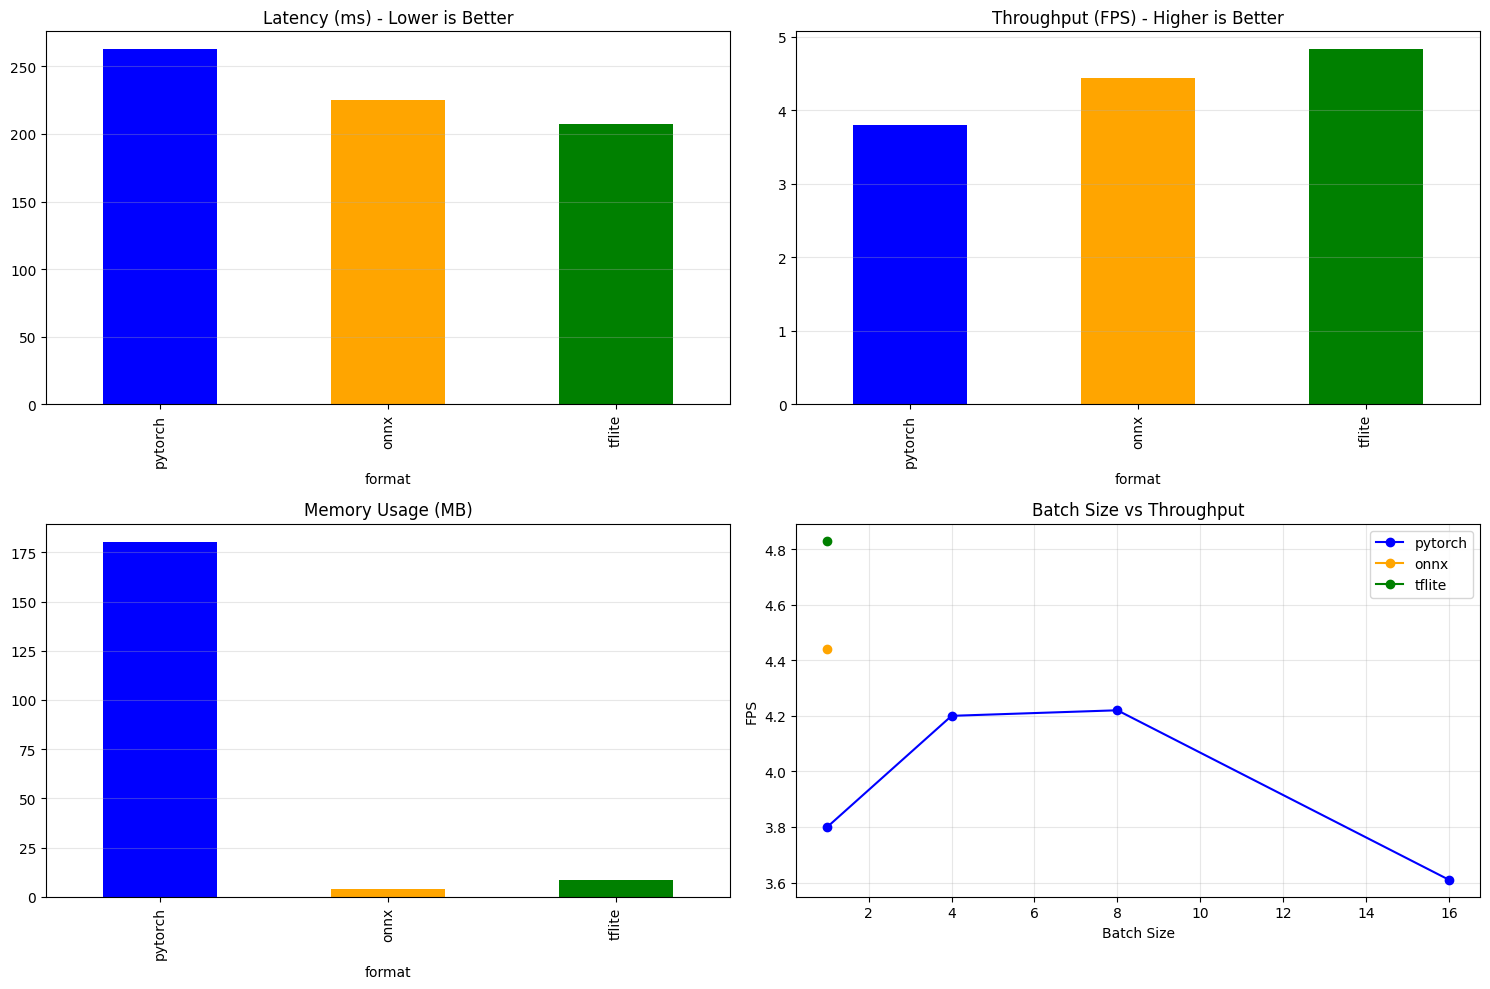


💾 Results saved to:
  📊 /content/benchmark_results_20250717_101239/results.csv
  📈 /content/benchmark_results_20250717_101239/benchmark_results.png


In [9]:
# Execute the benchmark
results = run_benchmark()

## 7. Optional: Quick Results Summary

In [10]:
# Display a quick summary if you want
if 'results' in locals() and results is not None:
    print("\n📈 QUICK SUMMARY")
    print("-" * 30)

    # Best performers
    fastest = results.loc[results['throughput_fps'].idxmax()]
    lowest_latency = results.loc[results['avg_latency_ms'].idxmin()]

    print(f"🏆 Highest Throughput: {fastest['format']} - {fastest['throughput_fps']} FPS")
    print(f"⚡ Lowest Latency: {lowest_latency['format']} - {lowest_latency['avg_latency_ms']} ms")

    # Format comparison (batch size 1)
    batch1 = results[results['batch_size'] == 1]
    if len(batch1) > 0:
        print(f"\n📊 Format Comparison (Batch Size 1):")
        for _, row in batch1.iterrows():
            print(f"  {row['format']:8}: {row['throughput_fps']:6.1f} FPS, {row['avg_latency_ms']:6.1f}ms")


📈 QUICK SUMMARY
------------------------------
🏆 Highest Throughput: tflite - 4.83 FPS
⚡ Lowest Latency: tflite - 207.22 ms

📊 Format Comparison (Batch Size 1):
  pytorch :    3.8 FPS,  262.8ms
  onnx    :    4.4 FPS,  225.2ms
  tflite  :    4.8 FPS,  207.2ms


## Usage Instructions:

1. **Upload your models** to `/content/models/` or update the paths in step 2
2. **Run each cell** in order  
3. **Check results** in the generated plots and CSV files
4. **Download results** from the `/content/benchmark_results_[timestamp]/` folder